In [ ]:
# Mounting Google Drive and setting data directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data/

Mounted at /content/drive
/content/drive/MyDrive/data


In [ ]:
#libraries
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam

In [ ]:
#below line is for testing purpose only
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/wce/data/',image_size=(224,224),batch_size=2, shuffle=True, label_mode='binary')

data_path = '/content/drive/MyDrive/wce/data/'
class_folders = ['bleeding', 'non-bleeding']

images = []
labels = []

for class_folder in class_folders:
    class_path = os.path.join(data_path, class_folder, 'Images')
    class_label = 1 if class_folder == 'bleeding' else 0

    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image[..., ::-1])  #convert to RGB
            labels.append(class_label)
        else:
            print(f"Warning: Unable to read image '{image_path}'")

Found 2618 files belonging to 2 classes.


In [ ]:
# Function to extract color histogram features
def color_histogram_feature(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculating histograms for each channel
    hist_h = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    # Normalizing histograms
    hist_h /= hist_h.sum()
    hist_s /= hist_s.sum()
    hist_v /= hist_v.sum()

    # Concatenating histograms into a single feature vector
    features = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])
    # features1d = features.flatten()

    return features #dimension is [no. of images x 768] (256 + 256+ 256 for hue saturation value )

In [ ]:
def sift_feature(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Initializing SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # Detecting and computing keypoints and descriptors
    _, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is None:
        return np.zeros((768,))

    descriptors = descriptors.flatten()[:768]

    if len(descriptors) < 768:
        descriptors = np.pad(descriptors, (0, 768 - len(descriptors)), mode='constant', constant_values=0)

    return descriptors

In [ ]:
features = []

for i in range(len(images)):
    # Extracting color histogram features
    color_hist_features = color_histogram_feature(images[i])

    # Extracting SIFT features
    sift_features = sift_feature(images[i])

    # Concatenating features
    combined_features = np.concatenate([color_hist_features, sift_features.flatten()])

    features.append(combined_features)

features = np.array(features)
labels = np.array(labels)

In [ ]:
#CNN

# Define input shape
input_shape = (224, 224, 3)

# Assuming input_tensor is your input layer
input_tensor = Input(shape=input_shape, batch_size=8)

# Branch 1
branch1 = Conv2D(32, (1, 1), activation='relu', padding='same')(input_tensor)
branch1 = Conv2D(64, (3, 3), activation='relu', padding='same')(branch1)
branch1 = Conv2D(64, (5, 5), activation='relu', padding='same')(branch1)
branch1 = MaxPooling2D(pool_size=(2, 2))(branch1)
branch1 = MaxPooling2D(pool_size=(2, 2))(branch1)

# Creating a model for Branch 1
m1 = Model(inputs=input_tensor, outputs=branch1)

# Branch 2
branch2 = Conv2D(32, (1, 1), activation='relu', padding='same')(input_tensor)
branch2 = Conv2D(64, (3, 3), activation='relu', padding='same')(branch2)
branch2 = Conv2D(64, (5, 5), activation='relu', padding='same')(branch2)
branch2 = MaxPooling2D(pool_size=(2, 2))(branch2)
branch2 = Conv2D(64, (1, 1), activation='relu', padding='same')(branch2)
branch2 = Conv2D(64, (2, 2), activation='relu', padding='same')(branch2)
branch2 = Conv2D(128, (3, 3), activation='relu', padding='same')(branch2)
branch2 = Conv2D(128, (4, 4), activation='relu', padding='same')(branch2)
branch2 = MaxPooling2D(pool_size=(2, 2))(branch2)

# Creating a model for Branch 2
m2 = Model(inputs=input_tensor, outputs=branch2)

# Branch 3
branch3 = Conv2D(32, (1, 1), activation='relu', padding='same')(input_tensor)
branch3 = Conv2D(64, (3, 3), activation='relu', padding='same')(branch3)
branch3 = Conv2D(64, (5, 5), activation='relu', padding='same')(branch3)
branch3 = MaxPooling2D(pool_size=(2, 2))(branch3)
branch3 = Conv2D(64, (3, 3), activation='relu', padding='same')(branch3)
branch3 = Conv2D(64, (4, 4), activation='relu', padding='same')(branch3)
branch3 = Conv2D(128, (3, 3), activation='relu', padding='same')(branch3)
branch3 = Conv2D(64, (3, 3), activation='relu', padding='same')(branch3)
branch3 = MaxPooling2D(pool_size=(2, 2))(branch3)

# Creating a model for Branch 3
m3 = Model(inputs=input_tensor, outputs=branch3)

output1 = m1.output
output2 = m2.output
output3 = m3.output

# Concatenating the output tensors
cout1 = Concatenate()([output1, output2])
cout1 = Conv2D(128, (1, 1), activation='relu', padding='same')(cout1)

cout2 = Concatenate()([output1, output3])
cout2 = Conv2D(128, (1, 1), activation='relu', padding='same')(cout2)

concatenated_output_final = Concatenate()([cout1, cout2])

# Flatten and add Dense layers for final output
flat_output = Flatten()(concatenated_output_final)

# Creating a new model with the concatenated output as the final output
final_model = Model(inputs=input_tensor, outputs=flat_output)

final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model = final_model

batch_size = 2

cnn_features = []
for image in images:
    newfeatures = cnn_model.predict(np.expand_dims(image, axis=0)).flatten()
    cnn_features.append(newfeatures)

cnn_features = np.array(cnn_features)

final_features = np.concatenate((features, cnn_features), axis=1)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(final_features, labels, test_size=0.2, random_state=42)

# Final layer
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(final_features.shape[1],)),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1, batch_size=2, validation_split=0.2)

(8, 1)
917/917 [==============================] - 5572s 6s/step - loss: 0.3432 - accuracy: 0.8561 - val_loss: 0.1626 - val_accuracy: 0.9483


In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # Converting probabilities to binary predictions

# true labels and predicted labels
true_labels = y_test
predicted_labels = y_pred_class

1/1 [==============================] - 1s 1s/step


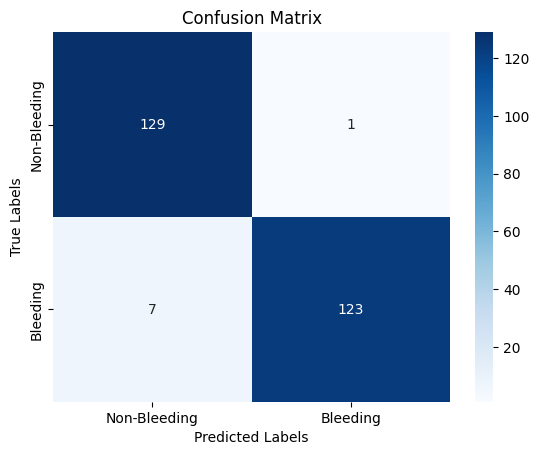

Classification Report:
               precision    recall  f1-score   support

Non-Bleeding       0.95      0.99      0.97       130
    Bleeding       0.99      0.95      0.97       130

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260

Precision: 0.9919355
Recall: 0.9461538
Binary Accuracy: 0.9692308
F1 Score: 0.96825397
True Label: [1.], Predicted Label: 1.0
True Label: [1.], Predicted Label: 1.0
True Label: [0.], Predicted Label: 0.0
True Label: [1.], Predicted Label: 1.0
True Label: [1.], Predicted Label: 1.0


In [ ]:
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bleeding', 'Bleeding'], yticklabels=['Non-Bleeding', 'Bleeding'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Non-Bleeding', 'Bleeding'])
print("Classification Report:\n", class_report)

# Quantitative Results
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Binary Accuracy:", acc.result().numpy())
print("F1 Score:", F1.numpy())

# Qualitative Analysis
num_samples_to_display = 5
indices_to_display = np.random.choice(len(true_labels), num_samples_to_display, replace=False)

for idx in indices_to_display:
    print(f"True Label: {true_labels[idx]}, Predicted Label: {predicted_labels[idx]}")



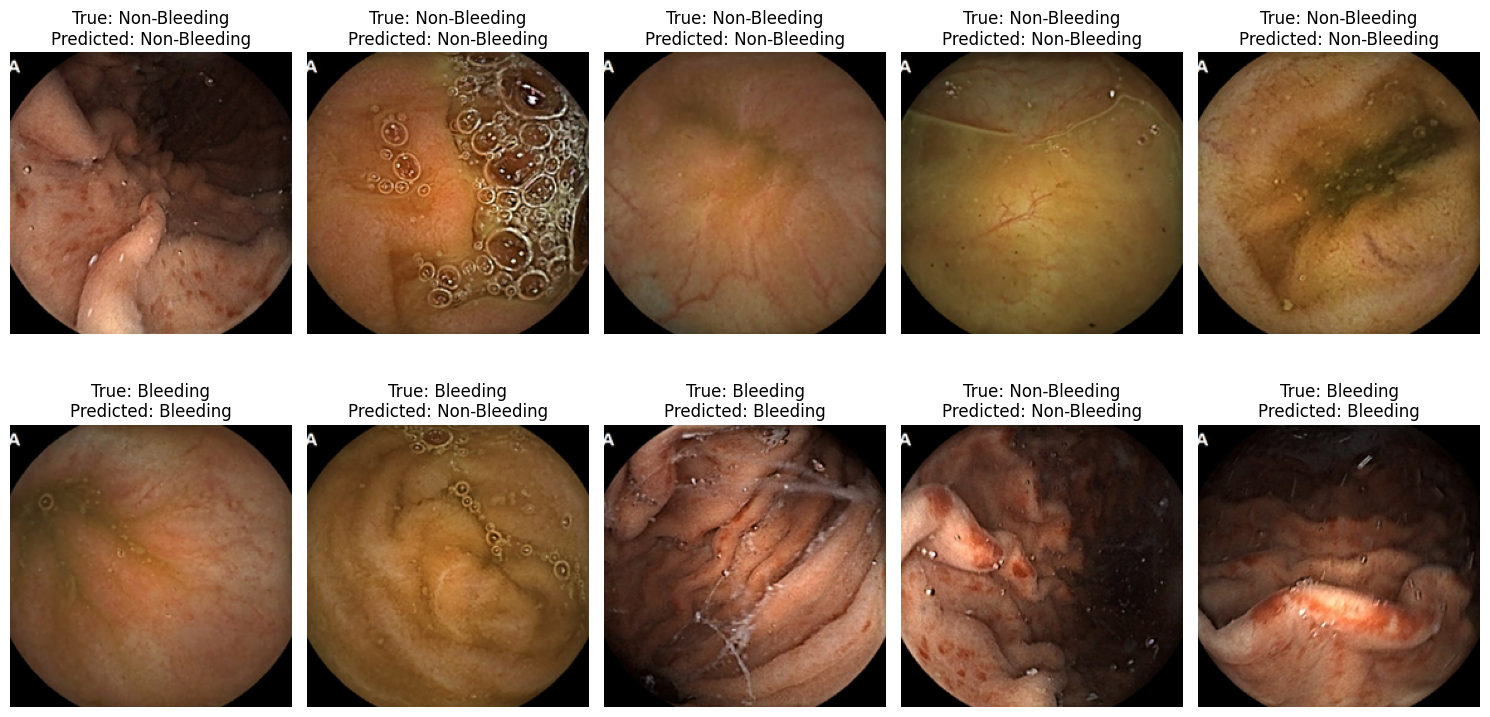

In [ ]:
indices_to_display = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # these are random

# Creating a 2x5 subplot grid
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
class_labels = ["Non-Bleeding", "Bleeding"]
for i, idx in enumerate(indices_to_display):
    # numerical labels to class names
    true_label = class_labels[int(true_labels[idx])]
    predicted_label = class_labels[int(predicted_labels[idx])]

    # photo
    axs[i // 5, i % 5].imshow(prediction_images[idx])
    axs[i // 5, i % 5].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axs[i // 5, i % 5].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image

test_data_dir = '/content/drive/MyDrive/test/'

# list of subdirectories in the test dataset directory
test_dataset_folders = [folder for folder in os.listdir(test_data_dir) if os.path.isdir(os.path.join(test_data_dir, folder))]

prediction_images = []
image_names = []

for test_folder in test_dataset_folders:
    test_folder_path = os.path.join(test_data_dir, test_folder)
    # list of all PNG image files in the folder
    image_files = [f for f in os.listdir(test_folder_path) if f.endswith('.png')]
    for image_file in image_files:
        # the full path to the image
        image_path = os.path.join(test_folder_path, image_file)
        image_height = 224
        image_width = 224

        img = Image.open(image_path)
        img = img.resize((image_width, image_height))
        prediction_images.append(np.array(img))

        image_names.append(image_file)

# predictions on the processed images using the trained image classification model
predictions = model.predict(np.array(prediction_images))

# Rounding the predictions to get binary class labels (0 or 1)
predicted_labels = np.round(predictions).astype(float)

# Creating a DataFrame to store image names and predicted class labels
df = pd.DataFrame({
    'Image Name': image_names,
    'Predicted Class Label': predicted_labels.flatten()  # Flattening the predictions to match the DataFrame shape
})

# Saving DataFrame to an Excel file
excel_filename = 'Result.xlsx'
df.to_excel(excel_filename, index=False)

print(f"Predictions saved to {excel_filename}")

17/17 [==============================] - 406s 23s/step
Predictions saved to Result.xlsx


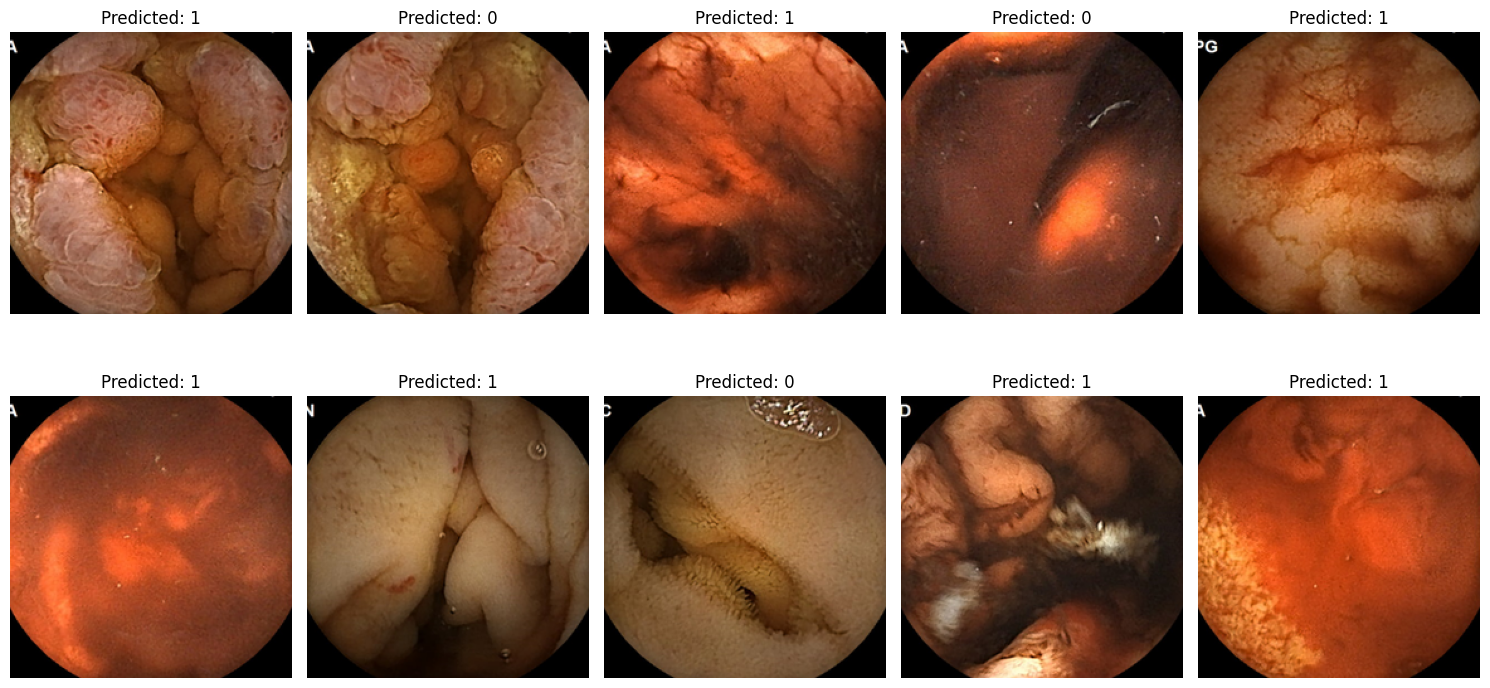

In [ ]:
# Selecting 10 random indices for displaying images
random_indices = np.random.choice(len(image_names), size=10, replace=False)

# Plotting 10 images along with their predicted labels
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(prediction_images[idx])
    plt.title(f'Predicted: {int(predicted_labels[idx])}')
    plt.axis('off')

plt.tight_layout()
plt.show()